In [1]:
import torch
import umap.umap_ as umap
import numpy as np
import pandas as pd
import sklearn
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

c:\Users\Ivan1\anaconda3\envs\sb\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random
def setup_seed(seed: int = 42, deterministic: bool = False):

    random.seed(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False  
        
seed = 42
setup_seed(seed=seed)

In [ ]:
expr=pd.read_csv('Data/2.2/expr.csv').iloc[:,1:]
meta=pd.read_csv("Data/2.2/stateFate_inVitro_metadata.csv")
scaler = StandardScaler()
scaler.fit(expr[meta['Time point']!=4])
xs = pd.DataFrame(scaler.transform(expr), index = expr.index, columns = expr.columns)
pca = sklearn.decomposition.PCA(n_components = 50)
pca.fit(xs[meta['Time point']!=4].values)

xp = pd.DataFrame(pca.transform(xs))
# xp = pd.DataFrame(pca.fit_transform(xs))
um = umap.UMAP(n_components = 2, metric = 'euclidean', n_neighbors = 50)
data_day2=torch.from_numpy(xp[meta['Time point']==2].values)
data_day4=torch.from_numpy(xp[meta['Time point']==4].values)
data_day6=torch.from_numpy(xp[meta['Time point']==6].values)
x_seq=torch.cat([data_day2,data_day4,data_day6])
um.fit(torch.cat([data_day2,data_day6]))
xu = um.transform(x_seq)

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [4]:
from scope import computations as cmp
from scope import clustering as cl
from scope import pre_match as pm
from scope import visualizations as vi

data_lst = [data_day2,data_day6]
time_steps = [2,6]

cluster_centers, labels_list, best_k = cl.kmeans_auto([d.cuda() for d in data_lst],tol=1e-4,method='calinski_harabasz',max_k=8)
print(best_k)

max_variance_differences = cmp.max_adjacent_covariance_diagonal_differences(data_lst)
print(max_variance_differences)

# scal = cmp.eps_scalar()
eps_func = cmp.piecewise_eps_function(time_steps, max_variance_differences,snr=0.95,min_eps=0.1) 

[2, 4]
[46.82389616924064]


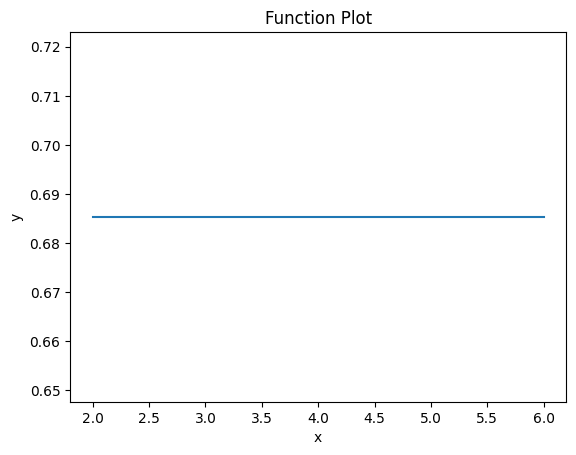

In [5]:
x = np.linspace(time_steps[0], time_steps[-1], 400)

y = [eps_func(x_i) for x_i in x]

plt.plot(x, y)

plt.title('Function Plot')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

INFO: Preparing data for visualization...
INFO: UMAP model provided. Transforming high-dimensional data to 2D...


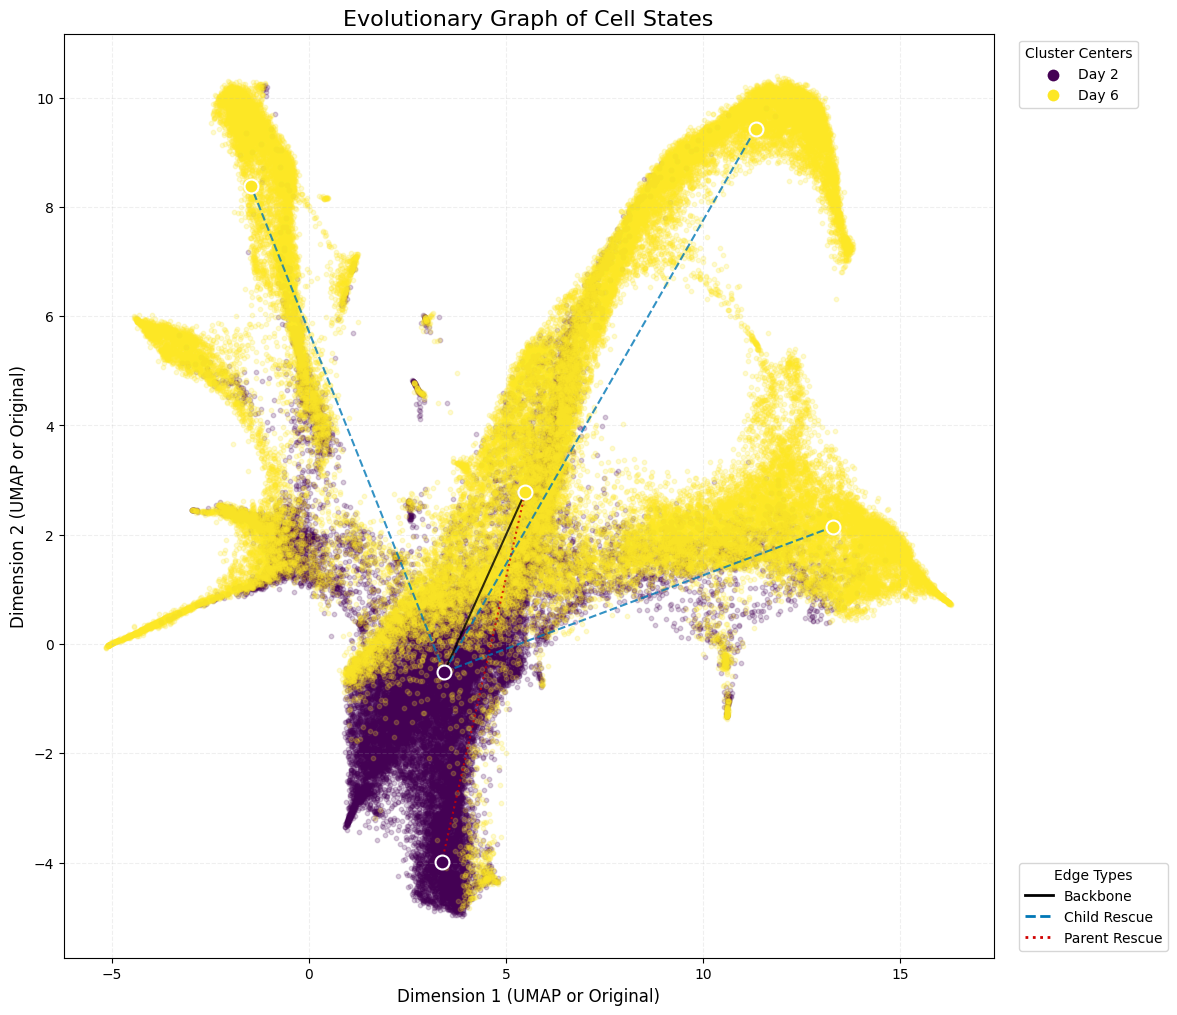

In [6]:
all_points_map, msf_edges = pm.calculate_evolutionary_graph([c.cpu().numpy() for c in cluster_centers],metric='euclidean')
vi.visualize_full_evolution(
    raw_data=[d.cpu().numpy() for d in data_lst],
    centers=[c.cpu().numpy() for c in cluster_centers],
    all_points_map=all_points_map,
    edges=msf_edges,
    time_labels=['Day ' + str(t) for t in time_steps],
    umap_model=um,
    save_path='./weinreb_interpolation_results/evolution_graph'
)

Re-indexing nodes to continuous integers...
Graph simplification and re-indexing complete.
INFO: Preparing data for visualization...
INFO: UMAP model provided. Transforming high-dimensional data to 2D...


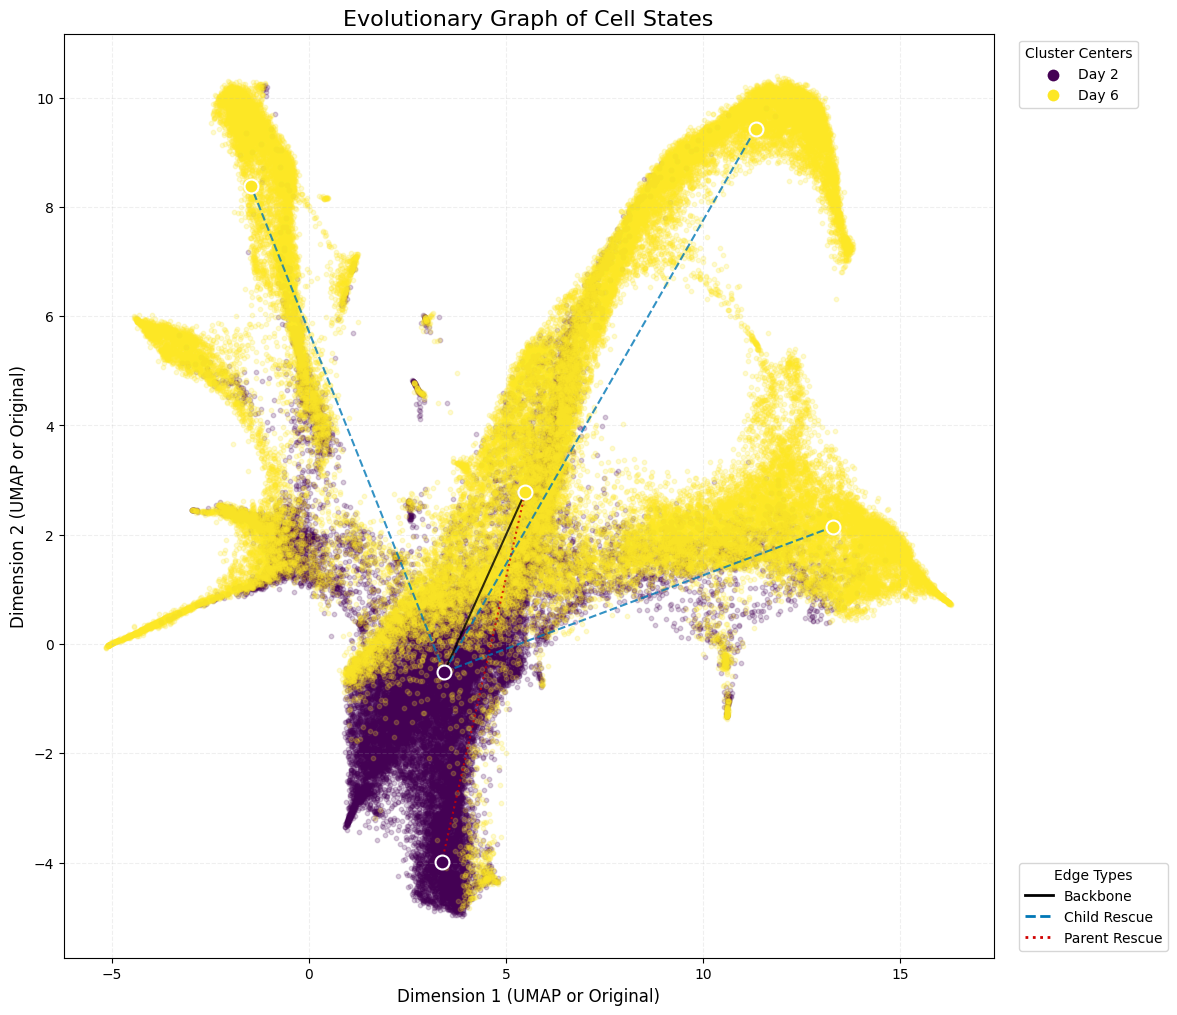

In [7]:
label_list_for_train = [cl.assign_labels(d.cuda(),cluster_centers[i].cuda()) for i, d in enumerate(data_lst)]
populations_map = cmp.count_cluster_samples(label_list_for_train)

all_points_map, cluster_centers, msf_edges = pm.simplify_evolutionary_graph(all_points_map, populations_map, msf_edges, epsilon_merge=10, theta_topo=0.5, metric='euclidean')
vi.visualize_full_evolution(
    raw_data=[d.cpu().numpy() for d in data_lst],
    centers=[c for c in cluster_centers],
    all_points_map=all_points_map,
    edges=msf_edges,
    time_labels=['Day ' + str(t) for t in time_steps],
    umap_model=um,
    save_path='./weinreb_interpolation_results/evolution_graph_simplified'
)
cluster_centers = [torch.from_numpy(c) for c in cluster_centers]

In [8]:
import scope.datasets as ds

label_list_for_train = [cl.assign_labels(d.cuda(),cluster_centers[i].cuda()) for i, d in enumerate(data_lst)]

2-6模型

INFO: 从演化图中找到了 5 条长度为 2 的有效路径（演化蓝图）。
defaultdict(<class 'float'>, {0: 0.49856157016913993, 2: 0.1711346340912781, 3: 0.17938511383110134, 1: 0.15091868190848076})


processed: 39:  98%|█████████▊| 39/40 [07:54<00:12, 12.17s/it, loss=340.14860061586296, loss_fore=333.7526208627593, loss_back=346.5445803689656]  


Early stopping at epoch 39


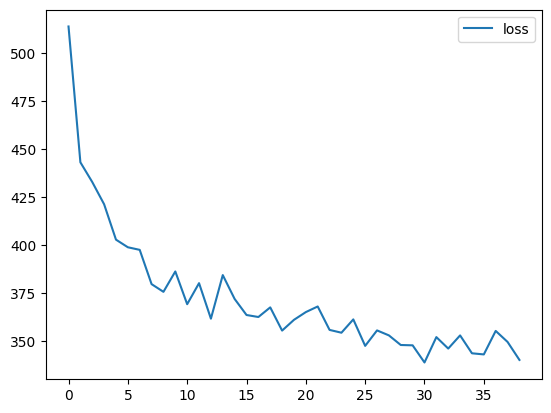

processed: 40: 100%|██████████| 40/40 [2:09:14<00:00, 193.86s/it, loss=245.146244929256, loss_back=245.146244929256]      


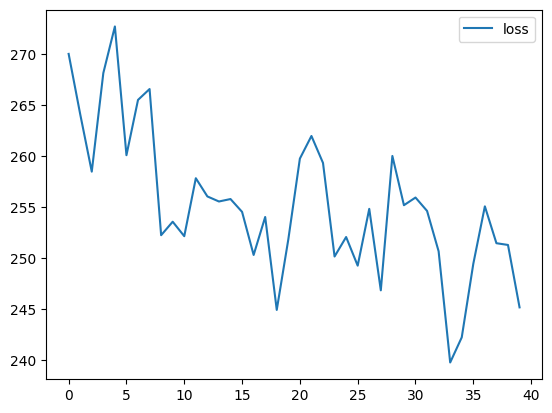

In [9]:
import scope
from scope import model
steps = 128
eps = eps_func

eps_test = eps_func
sb_object=model.sb_muti_model(data_lst,time_steps,N_pretraining=40,N_finetuning=40,backbone_lr=1e-3,finetuning_lr=1e-3,
                              steps=steps,eps=eps,early_stop=True,patience=8,B=128,lambda_=1e-3,save=True,record_gap=1,save_path='model_history/weinreb_interpolation_prematched',
                              prematched=True, label_list=label_list_for_train, edges=msf_edges, weighting_strategy='enos', beta=0.999)
sb_object.backbone_train()
sb_object.fine_tune(change=4)

In [10]:
fore_base=sb_object.eval_fore(data_day2.cuda().double(),sb_object.v_fore)
fore_ft=sb_object.eval_fore(data_day2.cuda().double(),sb_object.v_fore_fine_tuned)

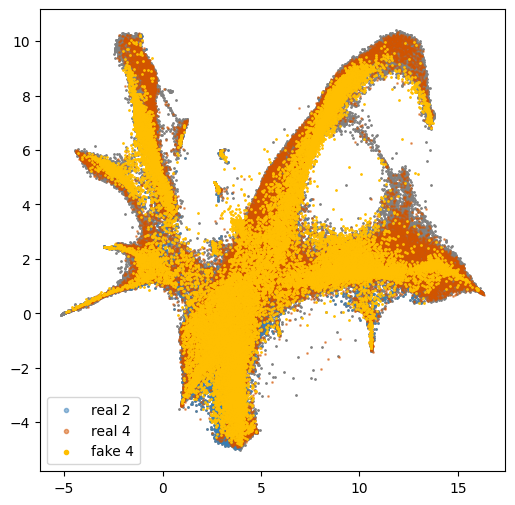

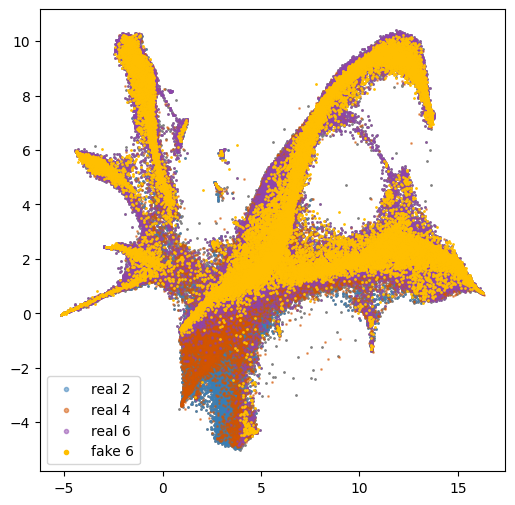

In [14]:
vi.visualize_generated_populations([data_day2,data_day4,data_day6],fore_base,[2,4,6],umap_model=um,save_path='./weinreb_interpolation_results/generated_populations')

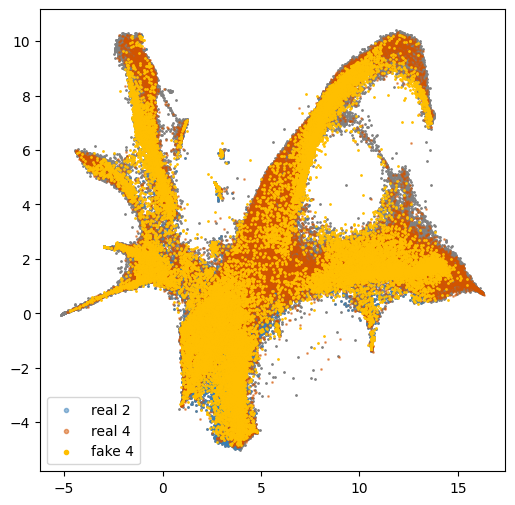

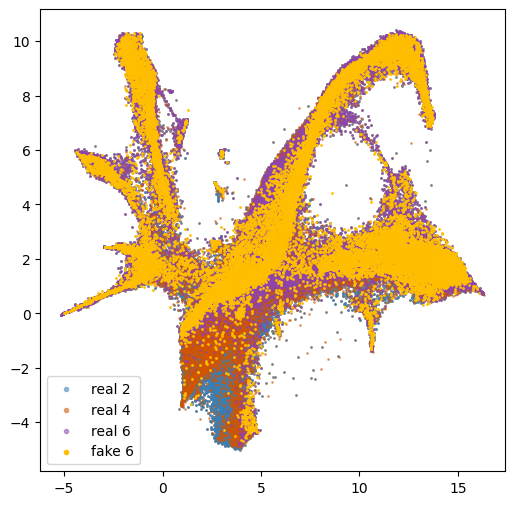

In [15]:
vi.visualize_generated_populations([data_day2,data_day4,data_day6],fore_ft,[2,4,6],umap_model=um,save_path='./weinreb_interpolation_results/generated_populations_fine_tuned')

In [13]:
from geomloss import SamplesLoss
ot_solver = SamplesLoss("sinkhorn", p = 2, blur = 0.1, scaling = 0.7,backend='auto')
tensor1 = torch.tensor(data_day4, dtype=torch.float32).contiguous().cuda()
tensor2 = torch.tensor(data_day6, dtype=torch.float32).contiguous().cuda()
tensor3 = torch.tensor(fore_base[len(fore_base)//2], dtype=torch.float32).contiguous().cuda()
tensor4 = torch.tensor(fore_base[-1], dtype=torch.float32).contiguous().cuda()
tensor5 = torch.tensor(fore_ft[len(fore_base)//2], dtype=torch.float32).contiguous().cuda()
tensor6 = torch.tensor(fore_ft[-1], dtype=torch.float32).contiguous().cuda()
print("backbone real4-fake4",ot_solver(tensor1[np.random.choice(data_day4.shape[0],10000),:], tensor3).item())
print("backbone real6-fake6",ot_solver(tensor2[np.random.choice(data_day6.shape[0],10000),:], tensor4).item())
print("finetuned real4-fake4",ot_solver(tensor1[np.random.choice(data_day4.shape[0],10000),:], tensor5).item())
print("finetuned real6-fake6",ot_solver(tensor2[np.random.choice(data_day6.shape[0],10000),:], tensor6).item())

/tmp/ipykernel_849/2662554511.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor1 = torch.tensor(data_day4, dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_849/2662554511.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor2 = torch.tensor(data_day6, dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_849/2662554511.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor3 = torch.tensor(fore_base[len(fore_base)//2], dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_849/2662554511.py:6: UserWarning: To co

backbone real4-fake4 50.71439743041992
backbone real6-fake6 29.232315063476562
finetuned real4-fake4 49.79730987548828
finetuned real6-fake6 38.88751220703125
